In [58]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
from imblearn import over_sampling
from sklearn import ensemble
from sklearn.metrics import confusion_matrix, recall_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import sklearn.model_selection as ms
plt.style.use('ggplot')

## Pre-Processing and Feature Engineering

In [8]:
# Use the TrafficFeature class to get the traffic volumes
collisions = pd.read_csv('new_collisions.csv')
traffic_byhour = pd.read_csv('traffic_byhour.csv')
traffic_bydayofweek = pd.read_csv('traffic_bydayofweek.csv')

In [9]:
# merge collisions dataset and two traffic datasets
# there may be missing values after joining, because only limited traffic volumes were only recorded on limited days
collisions = pd.merge(left=collisions, right=traffic_bydayofweek, how='left', on=['streetID','dayofweek'])
collisions = pd.merge(left=collisions, right=traffic_byhour, how='left', on=['streetID', 'time'])
collisions = collisions.dropna(subset = ['medianWeek', 'medianHour'])

# select columns that will be used in the model
collisions = collisions.loc[:,['NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED', 
       'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED', 
       'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED', 
       'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED', 
       'dayofweek', 'time', 'speed_bumps', 'speed_limits',
       'bike_lanes', 'medianWeek', 'medianHour']]
collisions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 944783 entries, 29 to 6849496
Data columns (total 15 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   NUMBER OF PERSONS INJURED      944783 non-null  float64
 1   NUMBER OF PERSONS KILLED       944783 non-null  float64
 2   NUMBER OF PEDESTRIANS INJURED  944783 non-null  int64  
 3   NUMBER OF PEDESTRIANS KILLED   944783 non-null  int64  
 4   NUMBER OF CYCLIST INJURED      944783 non-null  int64  
 5   NUMBER OF CYCLIST KILLED       944783 non-null  int64  
 6   NUMBER OF MOTORIST INJURED     944783 non-null  int64  
 7   NUMBER OF MOTORIST KILLED      944783 non-null  int64  
 8   dayofweek                      944783 non-null  int64  
 9   time                           944783 non-null  int64  
 10  speed_bumps                    944783 non-null  float64
 11  speed_limits                   944783 non-null  float64
 12  bike_lanes                  

In [26]:
#create df to compare model scores at the end of modeling
recall_scores = pd.DataFrame(columns=('Model', 'Score'))

In [12]:
#convert target variable to binary values
collisions['NUMBER OF PERSONS KILLED'].mask(collisions['NUMBER OF PERSONS KILLED'] > 1 , 1, inplace=True)

In [13]:
collisions['NUMBER OF PERSONS KILLED'].value_counts()

0.0    943394
1.0      1389
Name: NUMBER OF PERSONS KILLED, dtype: int64

In [33]:
#set target and predictor variables
X = collisions.loc[:,['dayofweek', 'time', 'speed_bumps', 'speed_limits', 'bike_lanes', 'medianWeek', 'medianHour']]
y = collisions.loc[:,['NUMBER OF PERSONS KILLED']]

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [34]:

#use as cv=skf, ensures results are consistent in each partition
s_kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True);


<AxesSubplot:ylabel='Count'>

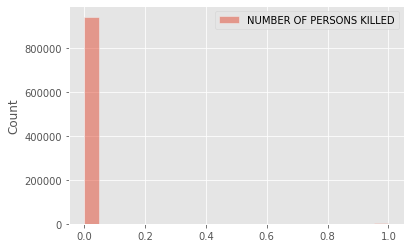

In [35]:
#seaborn histogram
sns.histplot(y)

In [36]:
# SMOTE upsampling for all models
oversample = over_sampling.SMOTE()
X_train_Bal, y_train_Bal = oversample.fit_resample(X_train, y_train)

y_train_Bal.value_counts()

NUMBER OF PERSONS KILLED
0.0                         660376
1.0                         660376
dtype: int64

## Correlation Matrix

In [37]:
# Correlation Matrix 
corr = collisions.corr().abs()
corr.style.background_gradient(cmap='coolwarm')

,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,dayofweek,time,speed_bumps,speed_limits,bike_lanes,medianWeek,medianHour
NUMBER OF PERSONS INJURED,1.000000,0.018299,0.310923,0.005999,0.211041,0.007687,0.880273,0.034389,0.007688,0.012763,0.016024,0.001330,0.011106,0.036192,0.040172
NUMBER OF PERSONS KILLED,0.018299,1.000000,0.001646,0.746239,0.003407,0.281223,0.020775,0.581112,0.000851,0.009005,0.002675,0.001815,0.000885,0.005736,0.010798
NUMBER OF PEDESTRIANS INJURED,0.310923,0.001646,1.000000,0.002204,0.042999,0.002749,0.069154,0.001523,0.019626,0.033282,0.015250,0.018552,0.001802,0.034077,0.034639
NUMBER OF PEDESTRIANS KILLED,0.005999,0.746239,0.002204,1.000000,0.005473,0.000309,0.003754,0.000638,0.004805,0.005024,0.001167,0.001695,0.000154,0.005104,0.009761
NUMBER OF CYCLIST INJURED,0.211041,0.003407,0.042999,0.005473,1.000000,0.011881,0.057423,0.004262,0.001379,0.035261,0.027423,0.011537,0.042723,0.015297,0.016904
NUMBER OF CYCLIST KILLED,0.007687,0.281223,0.002749,0.000309,0.011881,1.000000,0.005900,0.000241,0.001498,0.004428,0.004905,0.002944,0.006708,0.004429,0.004170
NUMBER OF MOTORIST INJURED,0.880273,0.020775,0.069154,0.003754,0.057423,0.005900,1.000000,0.037956,0.016078,0.012201,0.002332,0.012999,0.024693,0.019071,0.022895
NUMBER OF MOTORIST KILLED,0.034389,0.581112,0.001523,0.000638,0.004262,0.000241,0.037956,1.000000,0.005948,0.007638,0.000806,0.002203,0.001464,0.002057,0.004543
dayofweek,0.007688,0.000851,0.019626,0.004805,0.001379,0.001498,0.016078,0.005948,1.000000,0.015260,0.012254,0.003449,0.007447,0.027624,0.030754
time,0.012763,0.009005,0.033282,0.005024,0.035261,0.004428,0.012201,0.007638,0.015260,1.000000,0.004650,0.007728,0.023517,0.004536,0.116988


## Logistic Regression

In [50]:
# SMOTE balancing
logistic = LogisticRegression()
logistic.fit(X_train_Bal, y_train_Bal)
logistic.score(X_test, y_test)

SMOTE_logit = recall_score(y_test,logistic.predict(X_test))
print("Logistic Regression Recall Score: ", SMOTE_logit)

Logistic Regression Recall Score:  0.5827338129496403


In [51]:
# add first result in empty df
recall_scores.loc[0] = 'Logistic', round(SMOTE_logit, 2)

,Feature,Score
3,speed_limits,0.333627
2,speed_bumps,0.120076
0,dayofweek,0.044684
4,bike_lanes,0.033126
1,time,0.016962
6,medianHour,0.001758
5,medianWeek,0.001273


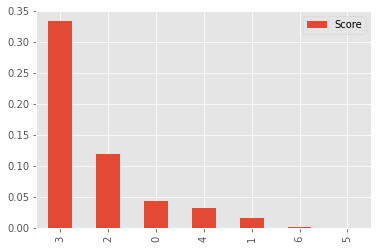

In [52]:
## Logistic Regression Feature Importance
importance = logit_final.coef_[0]
feature_importance = pd.DataFrame(columns = ('Feature', 'Score'))

# summarize feature importance
for i,v in enumerate(importance):
    feature_importance.loc[i] = X_train_Bal.columns[i], np.abs(v)
    
# plot feature importance
scores = feature_importance.sort_values(by = 'Score', ascending=False)
scores.plot.bar()
scores

## Random Forest

In [62]:
from sklearn import ensemble
randomForest = ensemble.RandomForestClassifier()

# fit RF model on SMOTE training set
randomForest.set_params(random_state=0)

randomForest.fit(X_train, y_train)

SMOTE_rf = recall_score(y_train, randomForest.predict(X_train))

# baseline score
print('SMOTE: \nRF BaseLine Train Set Recall Score:', SMOTE_rf)
#print('RF BaseLine Validation Set Recall Score:', recall_score(y_test, randomForest.predict(X_test)))

SMOTE: 
RF BaseLine Train Set Recall Score: 0.5205761316872428


In [63]:
#add to df for comparison
recall_scores.loc[1] = 'RF', round(SMOTE_rf, 2)

## KNN

In [66]:
knn = KNeighborsClassifier()
knn.fit(X_train_Bal, y_train_Bal)

SMOTE_knn = recall_score(y_train_Bal,knn.predict(X_train_Bal))

print("SMOTE: \nKNN Baseline Training Set recall score: ", SMOTE_knn)
#print("KNN Baseline Validation Set recall score: ", recall_score(y_test,knn.predict(X_test)))

SMOTE: 
KNN Baseline Training Set recall score:  0.571725804693084


In [67]:
recall_scores.loc[2] = 'KNN', round(SMOTE_knn, 2)

## Comparing Models

,Model,Score
0,Logistic,0.58
1,RF,0.52
2,KNN,0.57


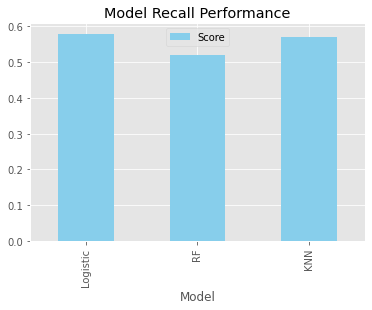

In [84]:
recall_scores.plot.bar(x = 'Model', color = 'skyblue')
plt.title('Model Recall Performance')
recall_scores